In [64]:
import matplotlib.pyplot as plt
import os
import json
from pathlib import Path
from enum import Enum
import scipy.constants as sc
from tensorboard.backend.event_processing.event_file_loader import EventFileLoader

In [65]:
# Enter paths for plot creation and get absolute paths.
paths = {
        "working_dir": "C:/Users/max.muehlefeldt/Documents/GitHub/unity-machine-learning/python/basic_rl_env",
        "results_dir": "results/",
        "results_archive_dir": "results_archive/",
        "stats_dir": "stats/"
    }

paths["working_dir"] = Path(paths["working_dir"]).absolute()

for key in paths:
    if key != "working_dir":
        paths[key] = paths["working_dir"] / paths[key]


In [66]:
# The runs in results and results_archive.
all_runs = {}
for file in os.listdir(paths["results_dir"]):
    all_runs[file.split("_")[0]] = paths["results_dir"] / file
for file in os.listdir(paths["results_archive_dir"]):
    all_runs[file.split("_")[0]] = paths["results_archive_dir"] / file


In [67]:
class Tag(Enum):
    CUMULATIVE_REWARD = "Environment/Cumulative Reward"
    EP_LENGTH = "Environment/Episode Length"

tag_colors = {
    Tag.CUMULATIVE_REWARD: "C1",
    Tag.EP_LENGTH: "C2"
    }

In [68]:
list(range(6072, 6081))

[6072, 6073, 6074, 6075, 6076, 6077, 6078, 6079, 6080]

Select from what run to get data. Also choose the Type of data.

In [69]:
multiple_runs = True
selected_runs: list[int] = [6072, 6073, 6074, 6075, 6076, 6077, 6078, 6079, 6080]
#selected_run = 1000
plot_step = 5
plot_all = True
selected_tag = Tag.EP_LENGTH

In [70]:
def get_tfevents_content_from_single_run(run_id: int) -> dict:  
    results = {}
    # Get the tfevents file associated with the current run.
    path_to_result_folder = all_runs[str(run_id)] / "RollerAgent/"
    path_to_result = sorted(Path(path_to_result_folder).glob("events.out.tfevents.*"))[0]

    path_to_stats_file: Path = paths["stats_dir"] / f"{run_id}_stats.json"
    #print(path_to_stats_file)
    if path_to_stats_file.exists():
        with open(path_to_stats_file) as json_file:
        #results["stats"] = json.load(json_file)
            results["stats"] = json.load(json_file)
        

    results["y_values"] = {
        Tag.CUMULATIVE_REWARD: [],
        Tag.EP_LENGTH: []
    }
    results["x_values"] = {
        Tag.CUMULATIVE_REWARD: [],
        Tag.EP_LENGTH: []
    }
    test = EventFileLoader(str(path_to_result)).Load()
    for event in EventFileLoader(str(path_to_result)).Load():
        # event = event_pb2.Event.FromString(batch.numpy())
        #y_values.append(event)
        for value in event.summary.value:
            if value.tag == Tag.CUMULATIVE_REWARD.value:
                results["y_values"][Tag.CUMULATIVE_REWARD].append(value.tensor.float_val[0])
                results["x_values"][Tag.CUMULATIVE_REWARD].append(event.step)
                
            if value.tag == Tag.EP_LENGTH.value:
                results["y_values"][Tag.EP_LENGTH].append(value.tensor.float_val[0])
                results["x_values"][Tag.EP_LENGTH].append(event.step)
    #y_values = y_values[::10]
    #len(results["y_values"][Tag.CUMULATIVE_REWARD])

    return results

In [71]:
content = {}
for r in selected_runs:
    content[r] = get_tfevents_content_from_single_run(r)
#content

In [72]:
content

{6072: {'stats': {'sameRoom': 51324,
   'agentInRoomID0': 51432,
   'agentInRoomID1': 51393,
   'targetInRoomID0': 51451,
   'targetInRoomID1': 51374,
   'episodeCount': 102825,
   'sensorCount': 1,
   'runId': 6072,
   'targetRoomIndex0': 51451,
   'targetRoomIndex1': 51374},
  'y_values': {<Tag.CUMULATIVE_REWARD: 'Environment/Cumulative Reward'>: [-22.220121383666992,
    -25.4480037689209,
    -20.76547622680664,
    -22.30600357055664,
    -24.530088424682617,
    -20.2508487701416,
    -18.502944946289062,
    -16.753097534179688,
    -22.694002151489258,
    -17.17082977294922,
    -13.786605834960938,
    -10.725624084472656,
    -9.953180313110352,
    -18.340572357177734,
    -13.781359672546387,
    -11.190377235412598,
    -12.195394515991211,
    -11.155844688415527,
    -13.250596046447754,
    -7.785913467407227,
    -15.332925796508789,
    -8.203167915344238,
    -11.381872177124023,
    -11.330698013305664,
    -9.685364723205566,
    -8.807229042053223,
    -8.3886528

In [73]:
from scipy.signal import savgol_filter

1
2
4
8
10
16
32
64
128


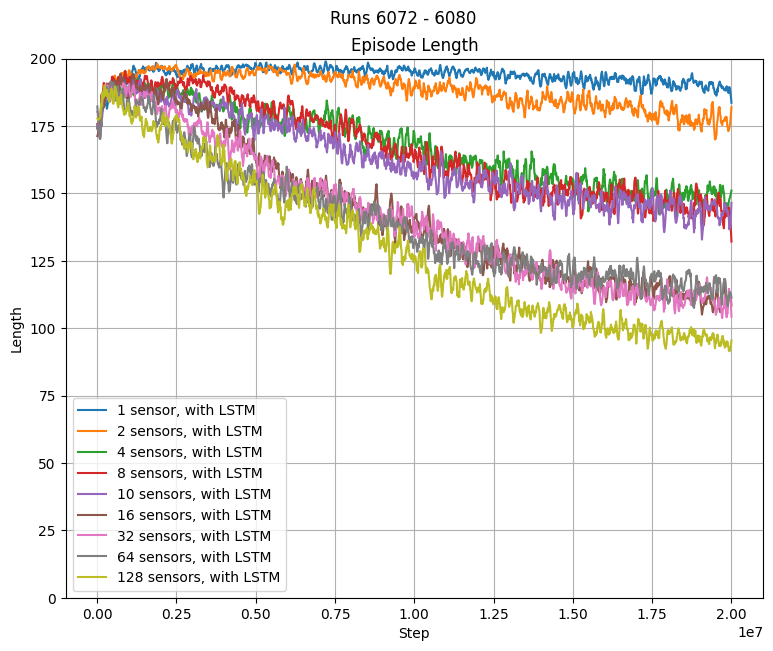

In [74]:
if len(selected_runs) > 1:
    fig = plt.figure(figsize=(9, 7))
    #fig = plt.figure()
    fig.patch.set_alpha(0.)
    
    gs = fig.add_gridspec(ncols=1, nrows=1, figure=fig)

    # First plot.
    #selected_tag = Tag.EP_LENGTH
    axs_first = fig.add_subplot(gs[0, 0])
    fig.suptitle(f"Runs {selected_runs[0]} - {selected_runs[-1]}", y=0.95)
    #fig.tight_layout()

    for id in selected_runs:
        sensor_count = content[id]['stats']['sensorCount']
        print(sensor_count)
        run_label = f"{sensor_count} sensor" if sensor_count == 1 else f"{sensor_count} sensors"
        #run_label = f"{sensor_count} sensor" if sensor_count == 1 else f"{sensor_count} sensors"
        run_label += f", no LSTM" if id == 6108 else ", with LSTM"
        x = content[id]["x_values"][selected_tag]
        y = savgol_filter( content[id]["y_values"][selected_tag], 15, 2)
        #x = content[id]["x_values"][selected_tag]
        axs_first.plot(
            x, 
            y,
            #color=tag_colors[selected_tag]
            label=run_label
            )
    
    
    if selected_tag is Tag.CUMULATIVE_REWARD:
        axs_first.set_ylim(-2, 1.5)
        axs_first.axhline(1.25, label="Reward limit = 1.25", color="C3", linestyle="dashed")
        axs_first.set_ylabel("Reward")

    elif selected_tag is Tag.EP_LENGTH:
        axs_first.set_ylim(0, 200)
        axs_first.set_ylabel("Length")

    axs_first.set_title(selected_tag.value.split("/")[-1])
    axs_first.set_xlabel("Step")
    
    axs_first.legend()
    axs_first.grid()   

    #handles, labels = axs_first.get_legend_handles_labels()
    #order = [1, 2, 3, 4, 5, 0, 6]
    #axs_first.legend(
    #    [handles[i] for i in order],
    #    [labels[i] for i in order])
    
    # Second plot.
    #selected_tag = Tag.EP_LENGTH
    #axs_second = fig.add_subplot(gs[1, 0])
    #axs_second.plot(x_values[selected_tag], y_values[selected_tag], color=tag_colors[selected_tag])
    #axs_second.set_title(selected_tag.value.split("/")[-1])
    #axs_second.set_ylim(0, 200)
    #axs_second.set_xlabel("Step")
    #axs_second.set_ylabel("Actions")
    #axs_second.grid()
    #axs_second.legend()

    plt.subplots_adjust(hspace=0.4)
    plt.style.use("default")

    #plt.savefig(f"{selected_run}_all.pdf")
    fig.savefig(f"{selected_runs[0]}-{selected_runs[-1]}_{selected_tag}.pdf")

In [28]:
for tag in y_values:
    assert len(x_values[tag]) == len(y_values[tag])
    if len(x_values[tag]) > 10000:
        x_values[tag] = x_values[tag][::100]
        y_values[tag] = y_values[tag][::100]

In [29]:
len(y_values[Tag.EP_LENGTH])

492

In [30]:
if not plot_all:#plt.rcParams["savefig.facecolor"] = "#000000"
#plt.rcParams["figure.facecolor"] = "#222222"
    fig = plt.figure()
    fig.patch.set_alpha(0.)

    plt.plot(x_values, y_values ,label="Run", color=tag_colors[selected_tag])
    plt.hlines(1.0, x_values[0], x_values[-1], label="Expected reward limit = 1.0", color="C3", linestyles="dashed")
    plt.title(f"Run {selected_run}, {selected_tag.value}")
    plt.xlabel("Step")
    plt.ylabel("Reward")
    plt.ylim(-5, 1.2)
    plt.legend()
    plt.grid()

    filename: str = f"{selected_run}_{selected_tag}.pdf"
    plt.savefig(filename)
    print(filename)

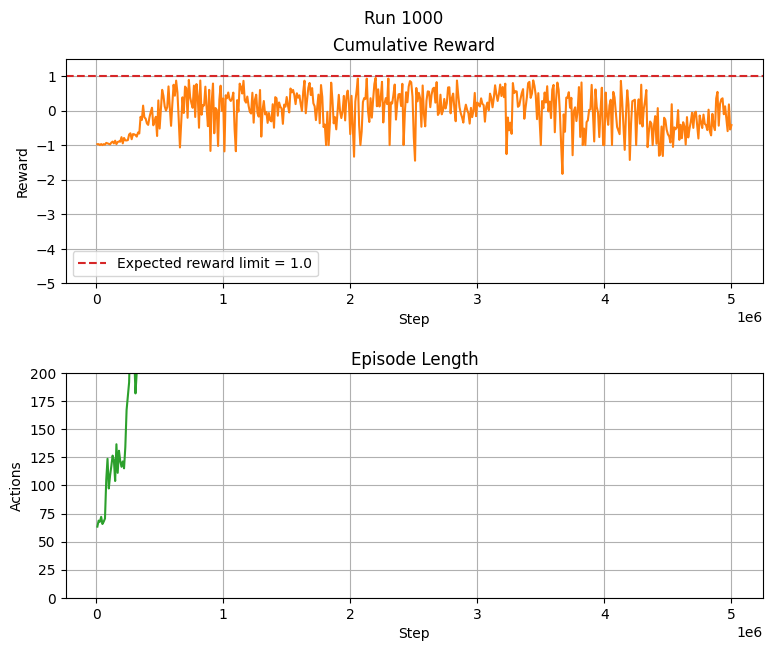

In [31]:
if plot_all:
    fig = plt.figure(figsize=(9, 7))
    #fig = plt.figure()
    fig.patch.set_alpha(0.)
    
    gs = fig.add_gridspec(ncols=1, nrows=2, figure=fig)

    # First plot.
    selected_tag = Tag.CUMULATIVE_REWARD
    axs_first = fig.add_subplot(gs[0, 0])
    fig.suptitle(f"Run {selected_run}", y=0.95)
    #fig.tight_layout()
    axs_first.plot(x_values[selected_tag], y_values[selected_tag] , color=tag_colors[selected_tag])
    axs_first.axhline(1.0, label="Expected reward limit = 1.0", color="C3", linestyle="dashed")
    axs_first.set_ylim(-5, 1.5)
    axs_first.set_title(selected_tag.value.split("/")[-1])
    axs_first.set_xlabel("Step")
    axs_first.set_ylabel("Reward")
    axs_first.legend()
    axs_first.grid()   

    # Second plot.
    selected_tag = Tag.EP_LENGTH
    axs_second = fig.add_subplot(gs[1, 0])
    axs_second.plot(x_values[selected_tag], y_values[selected_tag], color=tag_colors[selected_tag])
    axs_second.set_title(selected_tag.value.split("/")[-1])
    axs_second.set_ylim(0, 200)
    axs_second.set_xlabel("Step")
    axs_second.set_ylabel("Actions")
    axs_second.grid()
    #axs_second.legend()

    plt.subplots_adjust(hspace=0.4)

    #plt.savefig(f"{selected_run}_all.pdf")
    fig.savefig(f"{selected_run}_all.pdf")